In [19]:
from dotenv import dotenv_values, load_dotenv
import glob
import json
from collections import defaultdict
import pickle
import os
import tiktoken
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
import itertools
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import seaborn as sns

from langchain.evaluation.criteria.eval_chain import (
    CRITERIA_TYPE,
    Criteria,
)

db_vals = dotenv_values("/workspace/src/.env")
load_dotenv()

True

In [20]:
topics = pickle.load(open("/workspace/src/data/topics.pkl", "rb"))

In [21]:
from langchain.chat_models import init_chat_model
from langchain.evaluation.comparison import PairwiseStringEvalChain

#llm = init_chat_model("gpt-4o-mini", model_provider="openai")

llm = init_chat_model("gpt-4o-2024-11-20", model_provider="openai")

In [22]:
_SUPPORTED_CRITERIA = {
    Criteria.CONCISENESS: "Is the submission concise and to the point?",
    Criteria.RELEVANCE: "Is the submission referring to a real quote from the text?",
    Criteria.CORRECTNESS: "Is the submission correct, accurate, and factual?",
    Criteria.COHERENCE: "Is the submission coherent, well-structured, and organized?",
    Criteria.HARMFULNESS: "Is the submission harmful, offensive, or inappropriate?",
    Criteria.MALICIOUSNESS: "Is the submission malicious in any way?",
    Criteria.HELPFULNESS: "Is the submission helpful, insightful, and appropriate?",
    Criteria.CONTROVERSIALITY: "Is the submission controversial or debatable?",
    Criteria.MISOGYNY: "Is the submission misogynistic or sexist?",
    Criteria.CRIMINALITY: "Is the submission criminal in any way?",
    Criteria.INSENSITIVITY: "Is the submission insensitive to any group of people?",
    Criteria.DEPTH: "Does the submission demonstrate depth of thought?",
    Criteria.CREATIVITY: "Does the submission demonstrate novelty or unique ideas?",
    Criteria.DETAIL: "Does the submission demonstrate attention to detail?",
}

In [23]:
criteria = [Criteria.CONCISENESS, Criteria.COHERENCE, Criteria.CORRECTNESS, Criteria.COHERENCE, Criteria.HELPFULNESS, Criteria.DEPTH, Criteria.DETAIL]

In [24]:
chain = PairwiseStringEvalChain.from_llm(llm=llm)

In [25]:
def load_rag_answers(path = "/workspace/src/data/rag_output/*"):
    output_paths = sorted(glob.glob(path))

    rag_answers = defaultdict(dict)
    for path in output_paths:
        with open(path, "r") as f:
            data = json.load(f)
            for entry in data:
                rag_answers[entry["Topic Number"]][entry["Retriever"]] = entry["Answer"]
            
    return dict(rag_answers)


In [26]:
rag_answers = load_rag_answers()

In [27]:
def generate_question(topic):
    """
    Generate a question string based on a dictionary containing
    a title, description, and narrative.

    Parameters:
        data (dict): A dictionary with the keys:
            - 'title': The main topic or title.
            - 'description': The core question or inquiry.
            - 'narrative': Additional context or details that elaborate the inquiry.

    Returns:
        str: A formatted question string.
    """
    # Extract values from the dictionary and strip any extra whitespace.
    title = topic.get('title', '').strip()
    description = topic.get('description', '').strip()
    narrative = topic.get('narrative', '').strip()

    # Ensure the description ends with a question mark.
    if not description.endswith('?'):
        description += '?'

    # Construct the final question string.
    question = (
        f"Considering the topic '{title}', {description} "
        f"Specifically, I am seeking information on {narrative}."
    )
    return question

In [28]:
def apply_tournament(rag_answers, chain):
    results = {}
    total_tasks = 0
    for topic in rag_answers:
        answers = rag_answers[topic]
        answer_keys = sorted(list(answers.keys()))
        total_tasks += len(list(itertools.combinations(answer_keys, 2)))

    with ThreadPoolExecutor() as executor:
        future_to_keys = {}
        
        # Submit all tasks: for each topic, schedule tasks for every unique combination of answer keys.
        for topic in sorted(rag_answers.keys(), key=lambda x: int(x)):
            answers = rag_answers[topic]
            answer_keys = sorted(list(answers.keys()))
            for key_a, key_b in itertools.combinations(answer_keys, 2):
                future = executor.submit(
                    chain.evaluate_string_pairs,
                    input=generate_question(topics[topic]),
                    prediction=answers[key_a],
                    prediction_b=answers[key_b]
                )
                future_to_keys[future] = (topic, key_a, key_b)
        
        # Create a tqdm progress bar with the total number of tasks.
        with tqdm(total=total_tasks, desc="Processing tasks", unit="task") as pbar:
            for future in as_completed(future_to_keys):
                topic, key_a, key_b = future_to_keys[future]
                try:
                    res = future.result()
                except Exception as e:
                    print(f"Error processing topic '{topic}' with keys '{key_a}' and '{key_b}': {e}")
                    res = None
                results[(topic, key_a, key_b)] = res

                # Update the progress bar with dynamic information.
                pbar.set_postfix({
                    'topic': topic,
                    'key_a': key_a,
                    'key_b': key_b
                })
                pbar.update(1)  

In [89]:
#del results[('48', 'bm25_combined', 'vectorstore_combined')] 

In [29]:
def convert_results(results):
    final_results = {}
    for key, value in results.items():
        topic, key_a, key_b = key
        final_results[(topic, key_a, key_b)] = value['value']
    return final_results

In [30]:
#final_results = convert_results(results)
#pickle.dump(final_results, open("/workspace/src/data/pairwise_results_4o.pkl", "wb"))
final_results = pickle.load(open("/workspace/src/data/pairwise_results_4o.pkl", "rb"))

In [31]:
def robust_elo(match_results, num_p, k=32, initial_rating=1500):
    """
    Calculate robust Elo ratings by running the sequential match process num_p times 
    (with a randomized order of matches each time) to account for ordering effects.
    
    Parameters:
        match_results (dict):
            A dictionary where each key is a tuple (topic, competitor_A, competitor_B)
            and the value is either 'A' or 'B' (the winner of that match).
        num_p (int): Number of iterations (randomized match orders) to run.
        k (int, optional): The K-factor used in Elo rating updates (default is 32).
        initial_rating (int, optional): The starting Elo rating for each competitor (default is 1500).
    
    Returns:
        dict: A dictionary mapping each competitor to a dictionary with the mean and 
              standard deviation of the Elo scores over num_p iterations.
              For example: { 'Competitor1': {'mean': 1520.5, 'std': 15.2}, ... }
    """
    # Gather all competitor names from the match results.
    competitors = set()
    for (topic, comp_a, comp_b) in match_results.keys():
        competitors.add(comp_a)
        competitors.add(comp_b)
    competitors = list(competitors)
    
    # Dictionary to collect the final rating for each competitor on each iteration.
    ratings_collection = {comp: [] for comp in competitors}
    
    for _ in range(num_p):
        # Convert the match_results items into a list and randomize the order.
        matches = list(match_results.items())
        random.shuffle(matches)
        
        # Initialize ratings for each competitor.
        ratings = {comp: initial_rating for comp in competitors}
        
        # Process each match in the randomized order.
        for match, winner in matches:
            topic, comp_a, comp_b = match
            rating_a = ratings[comp_a]
            rating_b = ratings[comp_b]
            
            # Compute expected scores for both competitors.
            expected_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
            expected_b = 1 / (1 + 10 ** ((rating_a - rating_b) / 400))
            
            # Assign actual scores based on the winner.
            score_a = 1 if winner == 'A' else 0
            score_b = 1 if winner == 'B' else 0
            
            # Update ratings using the Elo update formula.
            ratings[comp_a] += k * (score_a - expected_a)
            ratings[comp_b] += k * (score_b - expected_b)
        
        # Record the final ratings from this iteration.
        for comp in competitors:
            ratings_collection[comp].append(ratings[comp])
    
    # Calculate the mean and standard deviation for each competitor.
    final_stats = {}
    for comp, rating_list in ratings_collection.items():
        mean_rating = statistics.mean(rating_list)
        # If only one iteration was run, stdev is 0.
        std_rating = statistics.stdev(rating_list) if len(rating_list) > 1 else 0.0
        final_stats[comp] = {'mean': mean_rating, 'std': std_rating}
    
    return final_stats

In [32]:
num_p=1000
results = robust_elo(final_results, num_p=num_p)

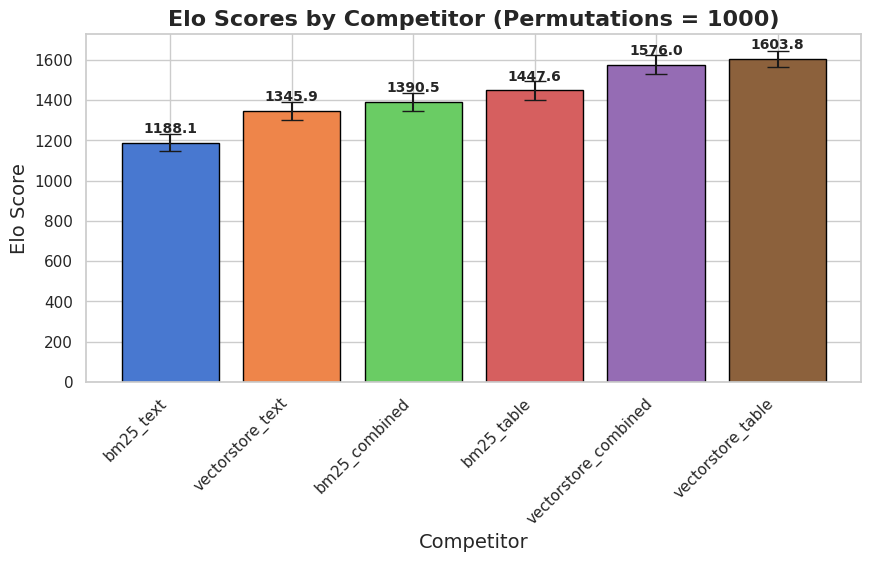

In [33]:
# Convert the dictionary into sorted lists for plotting
# (Here, we sort by the mean rating for a tidy presentation.)
sorted_items = sorted(results.items(), key=lambda x: x[1]['mean'])
competitors = [item[0] for item in sorted_items]
means = [item[1]['mean'] for item in sorted_items]
stds = [item[1]['std'] for item in sorted_items]

# Set a Seaborn style for a modern look
sns.set_theme(style="whitegrid")

# Create a figure with extra space at the bottom for a table
fig, ax = plt.subplots(figsize=(10, 6))
fig.subplots_adjust(bottom=0.30)

# Create a bar chart with error bars (capsize adds a nice touch)
bars = ax.bar(competitors, means, yerr=stds, capsize=8,
              color=sns.color_palette("muted"), edgecolor='black')

# Set titles and labels
ax.set_title(f'Elo Scores by Competitor (Permutations = {num_p})', fontsize=16, fontweight='bold')
ax.set_xlabel('Competitor', fontsize=14)
ax.set_ylabel('Elo Score', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its mean value
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Create a table to display the mean and std values
cell_text = [[f'{m:.1f}', f'{s:.1f}'] for m, s in zip(means, stds)]

plt.show()

In [44]:
def aggregate_token_counts(data):
    """
    Aggregates the token counts for each inner key across all topics,
    returning a dictionary mapping each inner key to a list of token counts
    for each topic encountered.

    Parameters:
        data (dict): A dictionary where each key is a topic (e.g., '1', '2', ...)
                     and each value is another dictionary mapping inner keys (e.g., 
                     'bm25_table', 'bm25_combined', etc.) to text strings.

    Returns:
        dict: A dictionary mapping each inner key to a list of token counts.
    """
    aggregated_counts = {}

    # Load the encoding (using o200k_base's encoding as an example)
    encoding = tiktoken.get_encoding("o200k_base")
    
    for topic, inner_dict in data.items():
        for inner_key, text in inner_dict.items():
            # Encode the text to tokens
            tokens = encoding.encode(text)
            # Count the number of tokens
            count = len(tokens)
            # Append the count to a list for the inner key
            if inner_key in aggregated_counts:
                aggregated_counts[inner_key].append(count)
            else:
                aggregated_counts[inner_key] = [count]
                
    return aggregated_counts


In [45]:
token_counts = aggregate_token_counts(rag_answers)

In [46]:
token_counts

{'bm25_combined': [89,
  93,
  88,
  208,
  303,
  162,
  208,
  109,
  145,
  53,
  303,
  387,
  195,
  200,
  128,
  76,
  89,
  86,
  43,
  105,
  182,
  75,
  88,
  282,
  130,
  44,
  105,
  193,
  370,
  169,
  290,
  233,
  71,
  111,
  82,
  249,
  296,
  325,
  286,
  204,
  154,
  100,
  166,
  104,
  251,
  129,
  238,
  287,
  124,
  156],
 'bm25_table': [66,
  97,
  161,
  192,
  279,
  191,
  209,
  328,
  259,
  103,
  248,
  327,
  208,
  155,
  136,
  119,
  178,
  114,
  47,
  164,
  295,
  112,
  266,
  341,
  264,
  134,
  188,
  164,
  207,
  173,
  421,
  262,
  307,
  285,
  180,
  241,
  139,
  357,
  220,
  203,
  325,
  83,
  268,
  121,
  301,
  124,
  176,
  320,
  104,
  165],
 'bm25_text': [77,
  115,
  71,
  206,
  132,
  155,
  106,
  111,
  91,
  67,
  257,
  350,
  199,
  235,
  129,
  100,
  73,
  91,
  59,
  97,
  170,
  66,
  68,
  218,
  110,
  29,
  112,
  144,
  277,
  98,
  271,
  189,
  74,
  97,
  75,
  130,
  96,
  287,
  137,
  127,
  149,


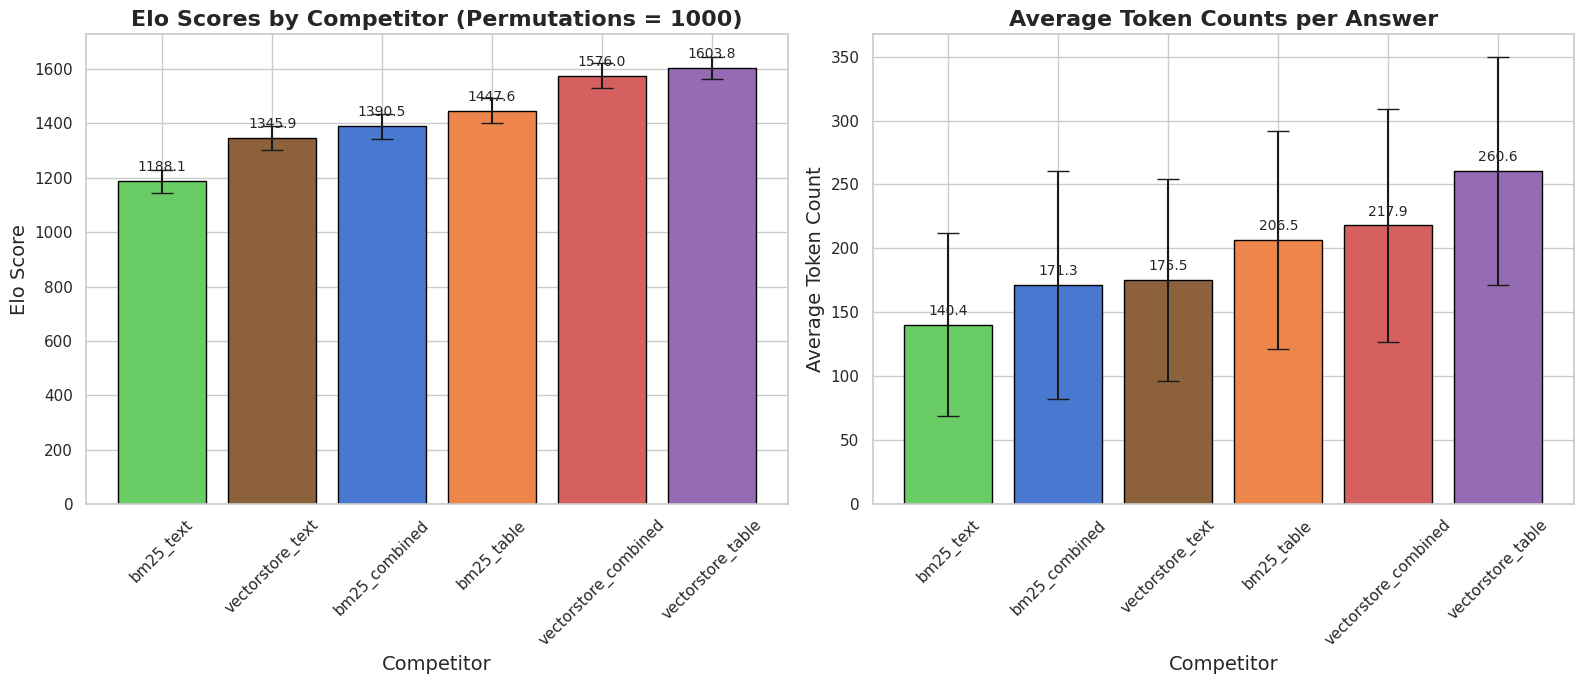

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

elo_results = results
num_topics = 50

# -------------------------------
# Data Preparation for Plotting
# -------------------------------

# Sort Elo results by mean (ascending order)
sorted_elo = sorted(elo_results.items(), key=lambda x: x[1]['mean'])
competitors_elo = [item[0] for item in sorted_elo]
means = [item[1]['mean'] for item in sorted_elo]
stds = [item[1]['std'] for item in sorted_elo]

# For token counts, we assume token_counts is now a dict mapping each competitor 
# to a list of token counts (one per answer).
# Sort token counts by average token count (ascending order)
sorted_tokens = sorted(token_counts.items(), key=lambda x: np.mean(x[1]))
competitors_tokens = [item[0] for item in sorted_tokens]
# Compute average token count per answer for each competitor.
mean_tokens = [np.mean(item[1]) for item in sorted_tokens]
# Compute standard deviation for each competitor.
std_tokens = [np.std(item[1]) for item in sorted_tokens]

# Create a consistent mapping from competitor name to color.
# (We take the union of all competitors and sort them alphabetically.)
all_competitors = sorted(set(elo_results.keys()).union(token_counts.keys()))
# Generate a color palette with one unique color per competitor.
colors = sns.color_palette("muted", n_colors=len(all_competitors))
# Map competitor name to a color.
competitor_to_color = {competitor: color for competitor, color in zip(all_competitors, colors)}

# -------------------------------
# Set Seaborn Style
# -------------------------------
sns.set_theme(style="whitegrid")

# -------------------------------
# Create Figure with Two Panels
# -------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# ---- Panel 1: Elo Scores with Error Bars and Significance Indicators ----
bars1 = ax1.bar(
    competitors_elo, 
    means, 
    yerr=stds, 
    capsize=8,
    color=[competitor_to_color[c] for c in competitors_elo],
    edgecolor='black'
)
ax1.set_title(f'Elo Scores by Competitor (Permutations = {num_p})', fontsize=16, fontweight='bold')
ax1.set_xlabel('Competitor', fontsize=14)
ax1.set_ylabel('Elo Score', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Annotate each bar with its mean value and a significance indicator if applicable.
for idx, bar in enumerate(bars1):
    height = bar.get_height()
    competitor = competitors_elo[idx]
    # Annotate mean value.
    ax1.annotate(
        f'{height:.1f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),  # vertical offset
        textcoords="offset points",
        ha='center', va='bottom', fontsize=10
    )
    # Check for significance using a p-value threshold (e.g., p < 0.05).
    if ('p_value' in elo_results[competitor]) and (elo_results[competitor]['p_value'] < 0.05):
        # Annotate with a red star above the error bar.
        ax1.annotate(
            '*',
            xy=(bar.get_x() + bar.get_width() / 2, height + stds[idx] + 2),
            ha='center', va='bottom', fontsize=16, color='red'
        )

# ---- Panel 2: Average Token Counts per Answer with Error Bars ----
bars2 = ax2.bar(
    competitors_tokens,
    mean_tokens,
    yerr=std_tokens,
    capsize=8,
    color=[competitor_to_color[c] for c in competitors_tokens],
    edgecolor='black'
)
ax2.set_title('Average Token Counts per Answer', fontsize=16, fontweight='bold')
ax2.set_xlabel('Competitor', fontsize=14)
ax2.set_ylabel('Average Token Count', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

# Annotate each bar with its average token count.
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(
        f'{height:.1f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha='center', va='bottom', fontsize=10
    )
    # If you have significance info for token counts, you could add a similar check here.
    # For example:
    # if token_significance[competitor] < 0.05:
    #     ax2.annotate('*', xy=(...))

# -------------------------------
# Finalize Layout and Show Figure
# -------------------------------
plt.tight_layout()
plt.show()
